# **Paying Attention to Transformers**

<img src="https://nlp.seas.harvard.edu/images/the-annotated-transformer_38_0.png" width="40%" />

<a href="https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2022/blob/intro-pos_encoding-tokenizing/attention_and_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> [THIS SHOULD STILL CHANGE TO OUR PRAC]

© Deep Learning Indaba 2022. Apache License 2.0.

**Authors:**

**Introduction:** 

The transformer architecture, introduced in Vaswani et al2017 .'s paper Attention is All You Need, has significantly impacted the deep learning field. It has arguably become the de-facto architecture for complex Natural Language Processing (NLP) tasks and can outperform benchmarks in various domains, including computer vision and reinforcement learning.

Transformers, as the title of the original paper implies, are almost entirely based on a concept known as attention. Attention allows models to "focus" on different parts of an input; while considering the entire context of the input, versus a RNN for example that operates on the data in a sequential manner.

In this practical, we will introduce attention in greater detail and build the entire transformer architecture block by block to see why it is such a robust and powerful architecture

**Topics:** 

Content: <font color='blue'>`Attention mechanisms, Transformers, NLP`</font>  
Level: <font color='grey'>`Advanced`</font>


**Aims/Learning Objectives:**

- Learn how different attention mechanisms can be implemented.
- Learn and create the basic building blocks from scratch for the most common transformer architectures.
- Learn how to train a sequence-sequence model.
- Create and train a small GPT inspired model.
- Learn how to use the [Hugging Face](https://huggingface.co/) library for quicker development cycles.

**Prerequisites:**

- Basic understanding of Jax and Haiku
- Basic understanding linear algebra
- RNN based sequence-sequence models
- Token/Word embedding techniques

**Outline:** 


**Before you start:**

For this practical, you will need to use a GPU to speed up training. To do this, go to the "Runtime" menu in Colab, select "Change runtime type" and then in the popup menu, choose "GPU" in the "Hardware accelerator" box.

## Installation and Imports

In [ ]:
## Install and import anything required. Capture hides the output from the cell. 
#@title Install and import required packages. (Run Cell)

! pip install git+https://github.com/deepmind/dm-haiku transformers datasets

import os
import math
import urllib.request

# https://stackoverflow.com/questions/68340858/in-google-colab-is-there-a-programing-way-to-check-which-runtime-like-gpu-or-tpu
if int(os.environ["COLAB_GPU"]) > 0:
  print("a GPU is connected.")
elif "COLAB_TPU_ADDR" in os.environ and os.environ["COLAB_TPU_ADDR"]:
  print("A TPU is connected.")
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
else:
  print("Only CPU accelerator is connected.")

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap

import haiku as hk
import transformers
from transformers import AutoTokenizer
import datasets

from PIL import Image

import torch
import torchvision

import matplotlib.pyplot as plt
import numpy as np


# pre dowloading huggingface models and tokenisers
AutoTokenizer.from_pretrained("bert-base-cased")


# download images used in notebook
urllib.request.urlretrieve(
  'https://images.unsplash.com/photo-1529778873920-4da4926a72c2?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxzZWFyY2h8MXx8Y3V0ZSUyMGNhdHxlbnwwfHwwfHw%3D&w=1000&q=80',
   "cat.png")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/deepmind/dm-haiku to /tmp/pip-req-build-5u2x9wbe
  Running command git clone -q https://github.com/deepmind/dm-haiku /tmp/pip-req-build-5u2x9wbe
     |████████████████████████████████| 4.4 MB 6.7 MB/s 
     |████████████████████████████████| 362 kB 56.8 MB/s 
     |████████████████████████████████| 6.6 MB 45.5 MB/s 
     |████████████████████████████████| 101 kB 13.4 MB/s 
     |████████████████████████████████| 596 kB 72.5 MB/s 
     |████████████████████████████████| 212 kB 56.4 MB/s 
     |████████████████████████████████| 1.1 MB 42.0 MB/s 
     |████████████████████████████████| 140 kB 58.8 MB/s 
     |████████████████████████████████| 127 kB 58.6 MB/s 
     |████████████████████████████████| 94 kB 3.8 MB/s 
     |████████████████████████████████| 144 kB 55.8 MB/s 
     |████████████████████████████████| 271 kB 45.6 MB/s 
  Created wheel for dm-haiku: file

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

('cat.png', <http.client.HTTPMessage at 0x7f9977901ed0>)

In [ ]:
#@title Helper Functions. (Run Cell)

def plot_position_encodings(P, max_tokens, d_model):
  plt.figure(figsize=(20,np.min([8,max_tokens])))
  im = plt.imshow(P, aspect="auto", cmap='Blues_r')
  plt.colorbar(im, cmap='blue')

  if d_model<=64:
    plt.xticks(range(d_model))
  if max_tokens <=32:
    plt.yticks(range(max_tokens))
  plt.xlabel('Embedding index')
  plt.ylabel('Position index')
  plt.show()


def plot_image_patches(patches):
  axes=[]
  fig=plt.figure(figsize=(25,25))
  for a in range(patches.shape[1]):
      axes.append(fig.add_subplot(1, patches.shape[1], a+1) ) 
      plt.imshow(patches[0][a])
  fig.tight_layout()    
  plt.show()

In [ ]:
#@title Check what device you are using (Run Cell)
print(f"Num devices: {jax.device_count()}")
print(f" Devices: {jax.devices()}")

Num devices: 1
 Devices: [CpuDevice(id=0)]


## **Attention**

[Content on why we need attention, how something like RNN tried to tackle the problem, and how we got to attention.]

[Roughly 30 to 35 minutes]

[Currently, we still need some math tasks (if we can not think of anything, leave out)]

### Initial attention mechanisms - <font color='blue'>`Beginner`</font>

[Can talk about how an RNN auto-encoder used attention between current states and previous hidden-states, and code up some of those attention mechanisms (such as dot product, additive and multiplicative attention)]

[ Can use [Attention? Attention!](https://lilianweng.github.io/posts/2018-06-24-attention/) or something similar for guidance]


**Dot product attention**

[talk about dot product and how it can be used for attention]

[Code up the attention implimentation]

In [ ]:
def dot_product_attention(hidden_state, current_state):
  raise NotImplementedError

**Multiplicative attention (or something else)**

[talk about multiplicative and how it can be used for attention and how it adds in learnable parameters]

[Code up the attention implimentation]

In [ ]:
def multiplicative_attention(hidden_state, current_state):
  raise NotImplementedError

### Self-attention - <font color='blue'>`Intermediate`</font>

Talk about how we progressed to self-attention mechanisms and deep dive into scaled dot product attention. Not important yet to know how it fits into MHA.

#### **Scaled dot product attention**

[Deep dive here, with intuition for what query, keys and values can be, why we scale it etc.]

[Focus on query, value and key matrices code in MHA section when we build the MHA block of code to be used in transformer models]

**Code Task:** Can you code up scaled dot product attention?

In [ ]:
# we need to code up from scratch the function
def scd_attention(query, key, value):

  # allow then to code up the formula on their own
  raise NotImplementedError

In [ ]:
# run to test your function

def check_scd_attention_function(scd_attention_function):
  # we still need to impliment this
  raise NotImplementedError

In [ ]:
# @title Answer to code task (Try not to peek until you've given it a good try!') 

def scd_attention(query, key, value):
  emb_dim = query.shape[-1]
  logits = jnp.matmul(query, jnp.swapaxes(key, -2, -1))
  scaled_logits = logits/jnp.sqrt(emb_dim)
  attention_weights = jax.nn.softmax(scaled_logits, axis=-1) 
  values = jnp.matmul(attention_weights, value)
  return values, attention_weights

#### **Masked scaled dot attention** 

[Talk about how in some cases we are not allowed to see into the future or other inputs, so now we add in the masked attention]

[Build upon the function above and add in mask]

**Code Task:** Try and implement the masking operation for your SCD function.

In [ ]:
# Code to be implemented during practical
def scd_with_mask_attention(query, key, value, mask=None):
  # CHANGE ME 
  raise NotImplementedError

In [ ]:
# @title Answer to code task (Try not to peek until you've given it a good try!'). This answer will be based on our previous answer.

def scd_with_mask_attention(query, key, value, mask=None):
  emb_dim = query.shape[-1]
  logits = jnp.matmul(query, jnp.swapaxes(key, -2, -1))

  if mask is not None:
    logits = jnp.where(mask, logits, -1e30) # same big negative value used in Haiku

  scaled_logits = logits/jnp.sqrt(emb_dim)
  attention_weights = jax.nn.softmax(scaled_logits, axis=-1) 
  attention = jnp.matmul(attention_weights, value)
  return attention, attention_weights


**Group Task:**

- Play with the mask you provide to your function and tell your friend what you see.
- Ask your friend if they think it's fair that we don't allow specific models to look into the future using self-attention.

### Multihead Attention - <font color='blue'>`Advanced`</font>

[Introduce the concept of MHA and why it can be useful in a models.]

[Talk about projecting Q,K,V to smaller dimensions to make training more efficient etc.]

[Code up haiku multi-head attention module that will be used in future transformer models]

**Code Task:** Code up a Haiku module that implements the entire multi-head attention mechanism. 


In [ ]:
class MultiHeadAttention(hk.Module):

  def __init__(
      self,
      num_heads,
      key_size,
      model_size = None,
      name = None,
  ):
    super().__init__(name=name)
    self.num_heads = num_heads
    self.key_size = key_size
    self.model_size = model_size or key_size * num_heads

  def __call__(self, query, key, value, mask = None):
    raise NotImplementedError


In [ ]:
# @title Answer to code task (Try not to peek until you've given it a good try!'). This answer will be based on our previous answer.

# TODO: ADD IN CORRECT ANSWER


**MHA vs other sequence methods (optional)**

[Talk about how it differs and the complexity differs and other differences. Like what was done in this [practical](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial6/Transformers_and_MHAttention.html)]

### Section Quiz 

[Test knowledge on all the previous material of attention]

In [ ]:
#@title Generate Quiz Form. (Run Cell)
from IPython.display import HTML
HTML(
"""
<iframe 
	src="https://forms.gle/zbJoTSz3nfYq1VrY6",
  width="80%" 
	height="1200px" >
	Loading...
</iframe>
"""
)

## **Transformers**


### Processing the input data - <font color='blue'>`Beginner to intermediate`</font>

#### Tokenisation

Before data can be fed into transformers, it has to be transformed into an acceptable format, in other words a sequence of tokens. Below we very briefly discuss how we can transform text and vision data into tokens that can be processed by transformers [source](https://huggingface.co/docs/transformers/preprocessing).

##### **Text**



Transformers can not handle raw strings. So to process text, the text is first split up into tokens, where after these tokens are indexed and each token assigned an embedding of size $d_{model}$. This new sequence of token embeddings are then fed into the transformer architecture. This idea is visualised below. 

\\

<img src="https://drive.google.com/uc?export=view&id=16euh4LADP_mcXywFwKKY3QQQkVplepiI" alt="drawing" width="350"/>


These token IDs are typically predicted when a model generates text, fills in missing words, etc.

This process of splitting up text into tokens and assigning an ID to each token is called [tokenisation](https://huggingface.co/docs/transformers/tokenizer_summary). There are various ways to tokenise text, with some methods being trained directly from the data. When using pre-trained transformers, it is crucial to use the same tokeniser that was used to train the model. The previous link has in-depth descriptions of many widely known techniques.

Below we show how the [Bert](https://arxiv.org/abs/1810.04805) models tokeniser tokenises a sentence. We use [Hugging Face](https://huggingface.co/) for this part, where we have a deep dive into Hugging Face later in this notebook.

In [ ]:
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
encoded_input = bert_tokenizer("The practical is so much fun")
print(f"Token IDs: {encoded_input['input_ids']}")

Token IDs: [101, 1109, 6691, 1110, 1177, 1277, 4106, 102]


Here we can see that the tokeniser returns the IDs for each token, as shown in the figure. But counting the number of IDs, we see that it is larger than the number of words in the sentence. Let's print the tokens associated with each ID.


In [ ]:
print(f"Tokens: {bert_tokenizer.decode(encoded_input['input_ids'])}")

Tokens: [CLS] The practical is so much fun [SEP]


We can see the tokeniser attaches new tokens, `[CLS]` and `[SEP]`, to the start and end of the sequence. This is a Bert specific requirement for training and inference. Adding special tokens is a very common thing to do. 

For instance, to pretrain specific transformers, they perform what is known as masked prediction. For this, random tokens in a sequence are replaced by the `[MASK]` token, and the model is trained to predict the correct token ID for the token replaced with that token. 

**Group task**:

- Discuss with a friend what you think the current issue is when feeding these raw tokens into a transformer architecture? Think about the difference in meaning between a sentence and that same sentence where the word orders are random.
- How would you fix that issue? 

##### **Images** (optional)

As mentioned, transformers are versatile and can be applied to roughly any data which can be converted into a sequence of tokens.

For example, to use the transformers encoder architecture with images, one can split an image into different patches, flatten these image patches and project each image patch into a fixed-sized embedding using any projection method. By doing this, the image has been converted into a sequence of image tokens, and the transformer will be able to process the data. 

This process is shown in the image below. 

\\

<img src="https://drive.google.com/uc?export=view&id=1ERF0f3Y_0wNb4kQ07xMYUysqNYIPkQMD" alt="drawing" width="550"/>


**Code task (OPTIONAL and ADVANCED):** Write a function that can take in a batch of images with shape (Batch, Height, Widht, Channels) and divide it into equal-sized patches. You can use the output of `image_to_patch` and `plot_image_patches` functions to visualise and test your function.

In [ ]:
def image_to_patch(image, patch_size):
    """
    Inputs:
        x - array of shape [B, H, W, C]
        patch_size - Number of pixels per dimension of the patches (integer)
    """
    B, H, W, C = image.shape

    # FINISH ME

    return image_patches

Original image:


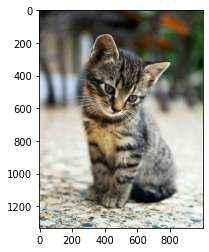

Image broken into patches


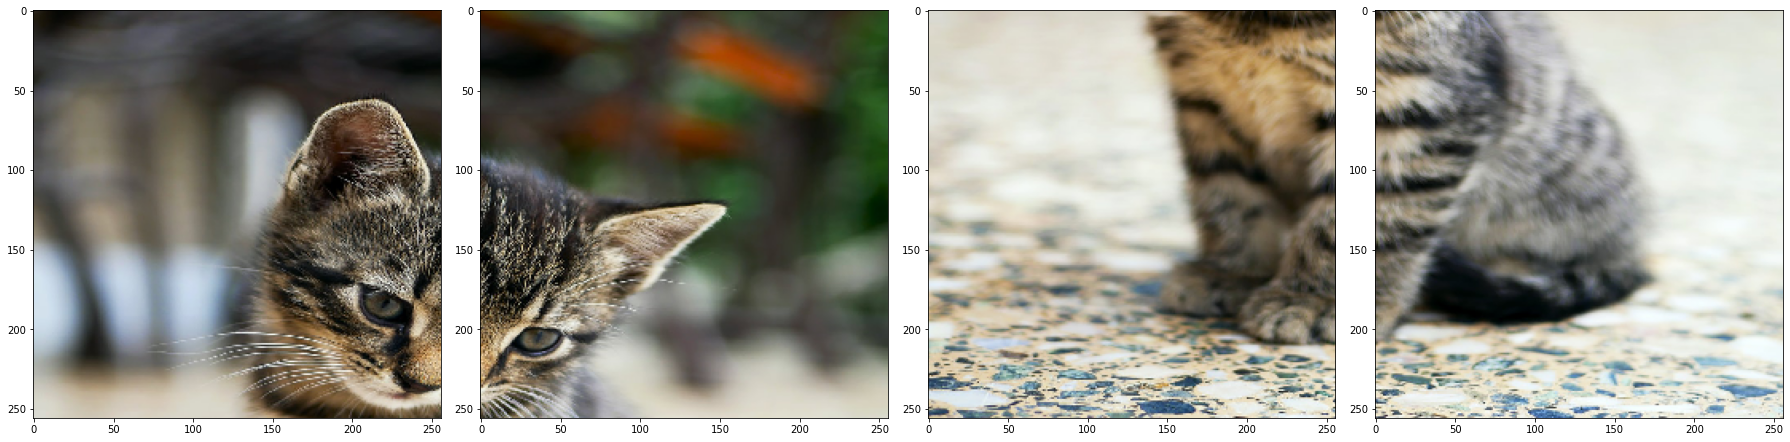

In [ ]:
# do not change these lines, only run them to test your function
print('Original image:')
image = np.array(Image.open("cat.png"))
plt.imshow(image)
plt.show()

print("Image broken into patches")
img = jnp.array(image)
img = jax.image.resize(img, (512,512,3), "nearest")
img = jnp.expand_dims(img, 0)
patches = image_to_patch(img, 256)
plot_image_patches(patches)

In [ ]:
# @title Answer to code task (Try not to peek until you've given it a good try!'). This answer will be based on our previous answer.

def image_to_patch(image, patch_size):
    """
    Inputs:
        x - array of shape [B, H, W, C]
        patch_size - Number of pixels per dimension of the patches (integer)
    """
    B, H, W, C = image.shape
    image = image.reshape(B, H//patch_size, patch_size, W//patch_size, patch_size, C)
    image = image.transpose(0, 1, 3, 2, 4, 5)    # [B, H', W', p_H, p_W, C]
    image_patches = image.reshape(B, -1, *image.shape[3:])   # [B, H'*W', p_H, p_W, C]
    return image_patches



#### Positional encoding 


#### Positional encoding 

In most domains where a transformer can be utilised, there is an underlying order to the tokens produced, be it the order of words in a sentence, the order in which patches are broken up or the steps taken in an environment. These sequence orders are very important; imagine you interpret the sentence "I have to read this book." as "I have this book to read.". Both sentences contain the exact same words; still, they have completely different meanings based on the order. 

As both the encoder and the decoder blocks process all tokens in parrel, the process does not know the sequence. To cope with this, the sequence order has to be injected into the tokens. This can be done by adding *positional encodings* to the tokens at the start of the encoder and decoder blocks (though some of the latest techniques add positional information in the attention blocks). An example of how positional encodings alter the tokens are shown below.

\\

<img src="https://drive.google.com/uc?export=view&id=1eSgnVN2hnEsrjdHygDGwk1kxEi8-dcFo" alt="drawing" width="450"/>

Ideally, these encodings should have these characteristics ([source](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/)):
* Each time-step should have a unique value
* The distance between time steps should stay constant.
* It should be able to generalise to longer sequences than seen during training.
* It must be deterministic.


##### **Sine and cosine functions**


In Attention is All you Need, the authors used a method that can satisfy all these requirements. This involves summing a combination of sine and cosine waves at different frequencies, with the formula for a position encoding at position $D$ shown below, where $i$ is the embedding index and $d_m$ is the token embedding size. 

\\

$P_{D}= \begin{cases}\sin \left(\frac{D}{10000^{i/d_{m}}}\right), & \text { if } i \bmod 2=0 \\ \cos \left(\frac{D}{10000^{((i-1)/d_{m}}}\right), & \text { otherwise } \end{cases}$

\\ 

Assuming our model as $d_m=8$, the position embedding will look like this:

$P_{D}=\left[\begin{array}{c}\sin \left(\frac{D}{10000^{0/8}}\right)\\ \cos \left(\frac{D}{10000^{0/8}}\right)\\ \sin \left(\frac{D}{10000^{2/8}}\right)\\ \cos \left(\frac{D}{10000^{2/8}}\right)\\ \sin \left(\frac{D}{10000^{4/8}}\right)\\ \cos \left(\frac{D}{10000^{4/8}}\right)\\ \sin \left(\frac{D}{10000^{8/8}}\right)\\ \cos \left(\frac{D}{10000^{8/8}}\right)\end{array}\right]$

\\

Let's first create a function that can return these encodings to get an intuition for why this will work. 


In [ ]:
def return_frequency_pe_matrix(token_sequence_length, token_embedding):

  assert token_embedding%2==0, "token_embedding should be divisible by two"

  P = jnp.zeros((token_sequence_length, token_embedding))
  positions = jnp.arange(0, token_sequence_length)[:, jnp.newaxis]

  i = jnp.arange(0, token_embedding, 2)
  frequency_steps = jnp.exp(i * (-math.log(10000.0) / token_embedding))
  frequencies = positions*frequency_steps

  P = P.at[:, 0::2].set(jnp.sin(frequencies))
  P = P.at[:, 1::2].set(jnp.cos(frequencies))

  return P

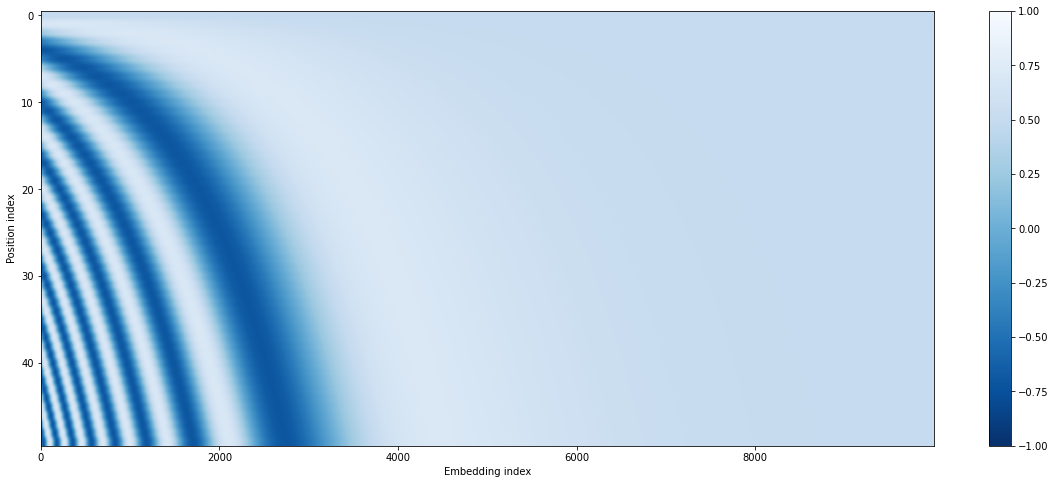

In [ ]:
token_sequence_length = 50 # Number of tokens the model will need to process
token_embedding = 10000 # token embedding (and positional encoding) dimensions, ensure it is divisible by two
P = return_frequency_pe_matrix(token_sequence_length, token_embedding)
plot_position_encodings(P, token_sequence_length, token_embedding)

Looking at the graph above, we can see that for each position index, their is a unique pattern forming. This can be interpet 

**Group task**:

- Discuss with your friend why we are seeing that specific pattern when `token_sequence_length` is 1000 and `token_embedding` is 768.
- You can try playing around with smaller values for `token_sequence_length` and  `token_embedding` to get a better intuition for the above disucssion.
- Ask your friend why they think the 10000 constant is used in the functions above. 
- Make `token_sequence_length` to be 50 and `token_embedding` something large, like 10000. What do you notice? Is a large token embedding always needed?


**Math task (optional):** Notice in our function that we do not directly implement the equation we describe above for numerical stability when calculating the frequency steps. See if you can derive by hand how we got to this new equation. Hint: Think about log rules.

Original equation:

$\text{frequencies} = \frac{D}{x^{i/d_{m}}}$

Code equation:

$\text{frequencies} = D\left(\text{exp} \left( \frac{-i\log(x)}{d_m} \right)\right)$

###### **Answer (but first try yourself)**

Expand this section to see the answer. 

What we did here is an essential aspect of computer science, specifically in machine learning, when big numbers appear. We usually rewrite equations to utilise logs, such that multiplications become additions and large numbers get suppressed. This ensures better numerical stability.  

\begin{align}
    \frac{𝐷}{x^{𝑖/𝑑𝑚}} &= D\left( x^{-i/dm}\right) \\
    &= D\left( \text{exp}\left(\log{x^{-i/dm}}\right)\right) \\
    &= D\left( \text{exp}\left(\frac{-i}{dm}\log{x}\right)\right) \\
    &= D\left( \text{exp}\left(\frac{-i\log{x}}{dm}\right)\right) \\
\end{align}

##### **Learned positional encodings**



Another method which is commonly used is to allow the model to learn the positional encodings on its own. In this method, the model learns a lookup table, where each index in the table refers to a position. Whereas the previous method allowed for an infinite amount of tokens, this method caps the maximum token sequence length. 

Using Haiku, this method is relatively straightforward as we can use [Haiku's embedd function](https://dm-haiku.readthedocs.io/en/latest/api.html#embed) or [Haiku's get parameter function](https://dm-haiku.readthedocs.io/en/latest/api.html#get-parameter)

**Code Task:** Try and implement a lookup table, which can be learned, for using Haikus get parameter function.



In [ ]:
class PositionEmbeddingsLookup(hk.Module):
    """
    A position embedding of shape [max_sequence_len, d_model]
    """
    def __init__(self, max_sequence_len, d_model):
        super().__init__()

        self.max_sequence_len = max_sequence_len
        self.d_model = d_model

    def __call__(self, sequence):
        
        assert sequence.shape[0]<=self.max_sequence_len, f"Sequence to long, max lenght={self.max_sequence_len}"

        lookup_table = hk.get_parameter( 
            name="position_embedding",# FILL ME IN
            shape=, # FILL ME IN
            init=jnp.zeros
        )

        return lookup_table[:sequence.shape[0], :]

In [ ]:
# @title Answer to code task (Try not to peek until you've given it a good try!'). This answer will be based on our previous answer.

class PositionEmbeddingsLookup(hk.Module):
    """
    A position embedding of shape [max_sequence_len, d_model]
    """
    def __init__(self, max_sequence_len, d_model):
        super().__init__()

        self.max_sequence_len = max_sequence_len
        self.d_model = d_model

    def __call__(self, sequence):
        
        assert sequence.shape[0]<=self.max_sequence_len, f"Sequence to long, max lenght={self.max_sequence_len}"

        lookup_table = hk.get_parameter(
            name="position_embedding", 
            shape=(self.max_sequence_len, self.d_model),
            init=jnp.zeros
        )

        return lookup_table[:sequence.shape[0], :]


### Section Quiz 

Optional end of section quiz. Below is an example of an assessment.

In [ ]:
#@title Generate Quiz Form. (Run Cell)
from IPython.display import HTML
HTML(
"""
<iframe 
	src="https://forms.gle/zbJoTSz3nfYq1VrY6",
  width="80%" 
	height="1200px" >
	Loading...
</iframe>
"""
)

## **Hugging Face (Optional)**


[Roughly 30 minutes, but most likely take home section]

[Can be used to also talk about image (or audio) transformers, how they work and how easy it is to just use them using HF]

[Show how much quicker it can be to use pre-trained models and why it is so heavilly used in industry]

## Conclusion
**Summary:**

[Summary of the main points/takeaways from the prac.]

**Next Steps:** 

[Next steps for people who have completed the prac, like optional reading (e.g. blogs, papers, courses, youtube videos). This could also link to other pracs.]

**Appendix:** 

[Anything (probably math heavy stuff) we don't have space for in the main practical sections.]

**References:** 

[References for any content used in the notebook.]

For other practicals from the Deep Learning Indaba, please visit [here](https://github.com/deep-learning-indaba/indaba-pracs-2022).

## Feedback

Please provide feedback that we can use to improve our practicals in the future.

In [ ]:
#@title Generate Feedback Form. (Run Cell)
from IPython.display import HTML
HTML(
"""
<iframe 
	src="https://forms.gle/bvLLPX74LMGrFefo9",
  width="80%" 
	height="1200px" >
	Loading...
</iframe>
"""
)

<img src="https://baobab.deeplearningindaba.com/static/media/indaba-logo-dark.d5a6196d.png" width="50%" />